In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet
from sklearn.svm import SVC, SVR
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, roc_curve, auc, confusion_matrix, \
                            plot_confusion_matrix, classification_report, make_scorer, f1_score, accuracy_score
from sklearn import metrics
import scikitplot as skplt

import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner as kt
from tensorflow import keras
from keras_tuner import RandomSearch, BayesianOptimization
from keras import metrics

import warnings
warnings.filterwarnings("ignore")

# Overview of Spam Prediction

- In this project, I use seven different models: Decision Tree, Linear/Logistic Regression, KNN, SVM, XGBoost, LightGBM and Neural Network to perform the same spam prediction using two kinds of objectives: model accuracy and business cost.
- Because of the imbalance distribution of targeted binary variable, both the two types of prediction models are modified using the class weights.

<br>

- For the model accuracy based prediction,
    - Within each model, I set hyperparameter space as follow:
        - Decision tree: "max_depth" : range(2,15), "min_samples_leaf": [2, 3, 4]
        - Linear regression: "C": [10\*\*i for i in range(1, 20)]
        - KNN: "n_neighbors": range(2,20), "weights": ["uniform", "distance"]
        - SVM: "C": [10\*\*i for i in range(1, 5)], "gamma": [10\*\*i for i in range(-3, 0)],   "kernel": "rbf"
        - XGBoost: 'learning_rate' :  [10\*\*i for i in range(-3, 0)], 'max_depth': range(3,11,2), "gamma": [10\*\*i for i in range(-3, 0)], 'n_estimators':[300, 500], 'colsample_bytree':[0.3, 0.7]
        - LightGBM: 'learning_rate' :  [10\*\*i for i in range(-3, 0)], 'max_depth': range(3,11,2), 'n_estimators':[300, 500], 'colsample_bytree':[0.3, 0.7]
        - NN: "num_layers": range(2,20), "num_neuron": min_value=32, max_value=512, step=32, "activation": ["relu", "tanh"], "dropout": 0.25
    - For each round of trying the hyperparameter, I use standardized normalization for scaling and calculate accuracy for model performance. 
    - After trying all the possible hyperparameters, I calculate the average accuracy for comparison.
        - Decision tree: 0.9081521739130434
        - Logistic regression: 0.9263586956521739
        - KNN: 0.919836956521739
        - SVM: 0.9315217391304348
        - XGBoost: 0.9505434782608696
        - LightGBM: 0.9510869565217391
        - NN: 0.9496923685073853
    - According to the comparison, we can conclude that LightGBM is the best model among all. 
    - Since the best model is LightGBM, I try GridSearch again on LightGBM for finding the best hyperparameter.
    - Finally, I test the LightGBM with best hyperparameter on testing data and output the confusion matrix, roc curve and lift curve.
    - The best model has a accuracy of 0.959. Specifically, f1 score for label 0 is 0.96, f1 score for label 1 is 0.98. Both of their AUC are 0.95
    
<br>

- For the business cost based prediction,
    - Within each model, I set hyperparameter space as follow:
        - Decision tree: "max_depth" : range(2,15), "min_samples_leaf": [2, 3, 4]
        - Logistic regression: "C": [10\*\*i for i in range(1, 20)]
        - KNN: "n_neighbors": range(2,20), "weights": ["uniform", "distance"]
        - SVM: "C": [10\*\*i for i in range(1, 5)], "gamma": [10\*\*i for i in range(-3, 0)],   "kernel": "rbf"
        - XGBoost: 'learning_rate' :  [10\*\*i for i in range(-3, 0)], 'max_depth': range(3,11,2), "gamma": [10\*\*i for i in range(-3, 0)], 'n_estimators':[300, 500], 'colsample_bytree':[0.3, 0.7]
        - LightGBM: 'learning_rate' :  [10\*\*i for i in range(-3, 0)], 'max_depth': range(3,11,2), 'n_estimators':[300, 500], 'colsample_bytree':[0.3, 0.7]
        - NN: "num_layers": range(2,20), "num_neuron": min_value=32, max_value=512, step=32, "activation": ["relu", "tanh"], "dropout": 0.25
    - For each round of trying the hyperparameter, I use standardized normalization for scaling and calculate business cost for model performance. 
    - After trying all the possible hyperparameters, I calculate the average business cost for comparison.
        - Decision tree: 281.25
        - Logistic regression: 297.25
        - KNN: 320.0
        - SVM: 282.5
        - XGBoost: 232.75
        - LightGBM: 156.5
        - NN: 338
    - According to the comparison, we can conclude that LightGBM is the best model among all. 
        - Since the best model is LightGBM, I try GridSearch again on LightGBM for finding the best hyperparameter.
    - Finally, I test the LightGBM with best hyperparameter on testing data and output the confusion matrix, roc curve and lift curve.
    - The best model has a cost at 156.

In [5]:
names_ls = [
"word_freq_make",
"word_freq_address",
"word_freq_all",
"word_freq_3d",
"word_freq_our",
"word_freq_over",
"word_freq_remove",
"word_freq_internet",
"word_freq_order",
"word_freq_mail",
"word_freq_receive",
"word_freq_will",
"word_freq_people",
"word_freq_report",
"word_freq_addresses",
"word_freq_free",
"word_freq_business",
"word_freq_email",
"word_freq_you",
"word_freq_credit",
"word_freq_your",
"word_freq_font",
"word_freq_000",
"word_freq_money",
"word_freq_hp",
"word_freq_hpl",
"word_freq_george",
"word_freq_650",
"word_freq_lab",
"word_freq_labs",
"word_freq_telnet",
"word_freq_857",
"word_freq_data",
"word_freq_415",
"word_freq_85",
"word_freq_technology",
"word_freq_1999",
"word_freq_parts",
"word_freq_pm",
"word_freq_direct",
"word_freq_cs",
"word_freq_meeting",
"word_freq_original",
"word_freq_project",
"word_freq_re",
"word_freq_edu",
"word_freq_table",
"word_freq_conference",
"char_freq_;",
"char_freq_(",
"char_freq_[",
"char_freq_!",
"char_freq_$",
"char_freq_#",
"capital_run_length_average",
"capital_run_length_longest",
"capital_run_length_total",
"target"
]

In [6]:
data = pd.read_csv("spambase.data", names = names_ls)

In [7]:
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [8]:
data_target = data.iloc[:,-1]
data_target.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [9]:
data_target.astype("string").describe()

count     4601
unique       2
top          0
freq      2788
Name: target, dtype: object

In [12]:
class_weights = compute_class_weight("balanced", np.unique(data_target), data_target)
class_weights = dict(zip(np.unique(data_target), class_weights))
class_weights

{0: 0.8251434720229556, 1: 1.2688913403199118}

In [13]:
counts = np.unique(data_target, return_counts = True)
counts

(array([0, 1]), array([2788, 1813]))

In [14]:
scale_pos_weights = counts[1][0]/counts[1][1]
scale_pos_weights

1.5377826806398236

In [15]:
data_target = data_target.to_numpy().reshape(data_target.shape[0], 1)

In [16]:
data_feature = data.iloc[:,0:57]
data_feature.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


## Classification based on Accuracy
### Machine Learning: Decision Tree, Logistic Regression, KNN, SVM, XGBoost, LightGBM

In [1098]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(data_feature, data_target, test_size=0.2, random_state=42)

# Define cross-validation set
inner_cv = KFold(n_splits=4, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=42)

# Find the best model
# Define a function
def NestedCV(param_grid, names, models, normalize, cv=inner_cv, scoring='accuracy'):
    cv_score = {}
    scaler = ColumnTransformer(
                transformers=[('ss', StandardScaler(), names_ls[:-1])],
                remainder="passthrough")
        
        
    for name, model, norm, param in zip(names, models, normalize, param_grid):
        print(name)
        normalization = norm
        if normalization:
            pipe = Pipeline([('scaler', scaler), ('estimator', model)])   
        else:
            pipe = Pipeline([('estimator', model)]) 
            
        clf = GridSearchCV(estimator=pipe, param_grid=param, n_jobs=-1, cv=cv, scoring=scoring, error_score = 'raise')
        score = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv)
        cv_score[name] = score.mean()
    return cv_score

In [200]:
# Define the hyperparameter space
dt_grid = {"estimator__max_depth" : list(range(2,15)),
          "estimator__min_samples_leaf": [2, 3, 4]}
lr_grid = {"estimator__C": [10**i for i in range(1, 20)]}
knn_grid = {"estimator__n_neighbors": list(range(2,20)),
          "estimator__weights": ["uniform", "distance"]}
svm_grid = {"estimator__C": [10**i for i in range(1, 5)],
          "estimator__gamma": [10**i for i in range(-3, 0)]
           #"estimator__decision_function_shape": ["ovo", "ovr"],
           #"estimator__kernel": ["linear", "poly", "rbf", "sigmoid"]
           }
xgb_grid = {'estimator__objective':['binary:logistic'],
            'estimator__learning_rate': [10**i for i in range(-3, 0)],
            'estimator__max_depth': list(range(3,11,2)), 
            'estimator__gamma':[10**i for i in range(-3, 0)],
            'estimator__n_estimators':[300, 500], 
            'estimator__colsample_bytree':[0.3, 0.7]}
lgbm_grid = {'estimator__objective':['binary'], 
             'estimator__learning_rate': [10**i for i in range(-3, 0)],
             'estimator__max_depth': list(range(3,11,2)),
             'estimator__n_estimators':[300, 500],
             'estimator__colsample_bytree':[0.3, 0.7]}

models_param_grid = [dt_grid, lr_grid, knn_grid, svm_grid, xgb_grid, lgbm_grid]

models = [DecisionTreeClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), 
          KNeighborsClassifier(),
          SVC(kernel = "rbf", class_weight=class_weights),
         XGBClassifier(scale_pos_weight = scale_pos_weights, 
                       tree_method = "gpu_hist"
                      ),
         LGBMClassifier(class_weight=class_weights, 
                        device = "gpu"
                       )]
names = ['DT', 'LR' ,'KNN' ,'SVC', "XGB", "LGBM"]
norm = [False, True, True, True, True, True]

In [148]:
NestedCV(param_grid= models_param_grid, models = models, names = names, normalize = norm)

DT
LR
KNN
SVC
XGB
LGBM


{'DT': 0.9081521739130434,
 'LR': 0.9263586956521739,
 'KNN': 0.919836956521739,
 'SVC': 0.9315217391304348,
 'XGB': 0.9505434782608696,
 'LGBM': 0.9510869565217391}

**Neural Network**

In [182]:
def build_model(hp):  
    model=Sequential()
    model.add(Flatten(input_dim=X_train.shape[1]))
    for i in range(hp.Int("num_layers",2,20)):         
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
    model.add(Dense(1, activation = "sigmoid")) 
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",values=[10**i for i in range(-4, 0)])),
                  loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [183]:
tuner=BayesianOptimization(build_model,
                           objective = "val_accuracy",
                           #objective=kt.Objective("root_mean_squared_error", direction="min"),
                           max_trials=10,
                           executions_per_trial=3,
                           overwrite=True)

In [184]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}


In [185]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  
              patience=20)], verbose=2, batch_size=10, class_weight=class_weights)

Trial 30 Complete [00h 01m 08s]
val_accuracy: 0.9363011121749878

Best val_accuracy So Far: 0.9496923685073853
Total elapsed time: 00h 27m 05s
INFO:tensorflow:Oracle triggered exit


### Hyperparameter Tuning for the Best Model

In [149]:
lgbm_grid = {'estimator__objective':['binary'], 
             'estimator__learning_rate': [10**i for i in range(-3, 0)],
             'estimator__max_depth': list(range(3,11,2)),
             'estimator__n_estimators':[300, 500],
             'estimator__colsample_bytree':[0.3, 0.7]}

lgbm = LGBMClassifier(class_weight=class_weights)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', lgbm)])

clf = GridSearchCV(estimator=pipe, param_grid=lgbm_grid, n_jobs=-1, cv=inner_cv, scoring='accuracy', error_score = 'raise')
grid_result = clf.fit(X_train, y_train)

print(f"Best score of gridsearch is {grid_result.best_score_}\n") 
print(f"The best hyperparameter of lgbm is  {grid_result.best_params_}\n")

Best score of gridsearch is 0.9565217391304348

The best hyperparameter of lgbm is  {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 5, 'estimator__n_estimators': 500, 'estimator__objective': 'binary'}



Testing set accuracy: 0.9587404994571118 

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       531
           1       0.96      0.94      0.95       390

    accuracy                           0.96       921
   macro avg       0.96      0.96      0.96       921
weighted avg       0.96      0.96      0.96       921



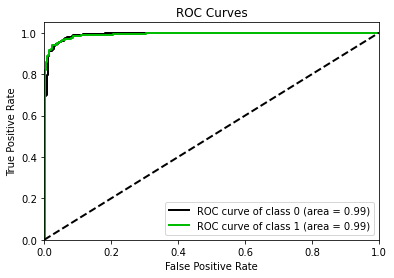

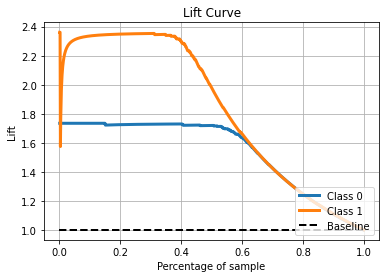

In [195]:
clf = LGBMClassifier(class_weight=class_weights, colsample_bytree = 0.3, learning_rate = .1, max_depth = 5, n_estimators = 500, objective = 'binary')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf.fit(X_train, y_train)
y_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print('Testing set accuracy:', accuracy_score(y_test, y_pred),'\n')

# Showing the classificatino report
print(classification_report(y_test, y_pred))

# Plot the ROC Curve
y_pred_proba = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba, plot_micro = False, plot_macro = False)
    
# Plot the Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_pred_proba)
plt.show()

## Classification based on Business Cost
### Machine Learning: Decision Tree, Logistic Regression, KNN, SVM, XGBoost, LightGBM

In [814]:
def cost_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cost = cm[0][1] * 10 + cm[1][0] * 1
    return cost

scoring_cost = make_scorer(cost_loss, greater_is_better= False)
# score will negate the return value of my_custom_loss_func

In [815]:
def NestedCV(param_grid, names, models, normalize, cv=inner_cv, scoring='accuracy'):
    cv_score = {}
    scaler = ColumnTransformer(
                transformers=[('ss', StandardScaler(), names_ls[:-1])],
                remainder="passthrough")
        
        
    for name, model, norm, param in zip(names, models, normalize, param_grid):
        print(name)
        normalization = norm
        if normalization:
            pipe = Pipeline([('scaler', scaler), ('estimator', model)])   
        else:
            pipe = Pipeline([('estimator', model)]) 
            
        clf = GridSearchCV(estimator=pipe, param_grid=param, n_jobs=-1, cv=cv, scoring=scoring, error_score = 'raise')
        score = cross_val_score(clf, X=X_train, y=y_train, cv=outer_cv)
        cv_score[name] = score.mean()
    return cv_score

# Define the hyperparameter space
dt_grid = {"estimator__max_depth" : list(range(2,15)),
          "estimator__min_samples_leaf": [2, 3, 4]}
lr_grid = {"estimator__C": [10**i for i in range(1, 20)]}
knn_grid = {"estimator__n_neighbors": list(range(2,20)),
          "estimator__weights": ["uniform", "distance"]}
svm_grid = {"estimator__C": [10**i for i in range(1, 5)],
          "estimator__gamma": [10**i for i in range(-3, 0)]
           #"estimator__decision_function_shape": ["ovo", "ovr"],
           #"estimator__kernel": ["linear", "poly", "rbf", "sigmoid"]
           }
xgb_grid = {'estimator__objective':['binary:logistic'],
            'estimator__learning_rate': [10**i for i in range(-3, 0)],
            'estimator__max_depth': list(range(3,11,2)), 
            'estimator__gamma':[10**i for i in range(-3, 0)],
            'estimator__n_estimators':[300, 500], 
            'estimator__colsample_bytree':[0.3, 0.7]}
lgbm_grid = {'estimator__objective':['binary'], 
             'estimator__learning_rate': [10**i for i in range(-3, 0)],
             'estimator__max_depth': list(range(3,11,2)),
             'estimator__n_estimators':[300, 500],
             'estimator__colsample_bytree':[0.3, 0.7]}

models_param_grid = [dt_grid, lr_grid, knn_grid, svm_grid, xgb_grid, lgbm_grid]

models = [DecisionTreeClassifier(class_weight=class_weights),
          LogisticRegression(class_weight=class_weights), 
          KNeighborsClassifier(),
          SVC(kernel = "rbf", class_weight=class_weights),
         XGBClassifier(scale_pos_weight = scale_pos_weights, 
                       tree_method = "gpu_hist"
                      ),
         LGBMClassifier(class_weight=class_weights, 
                        device = "gpu"
                       )]
names = ['DT', 'LR' ,'KNN' ,'SVC', "XGB", "LGBM"]
norm = [False, True, True, True, True, True]

In [201]:
NestedCV(param_grid= models_param_grid, models = models, names = names, normalize = norm, scoring = scoring_cost)

DT
LR
KNN
SVC
XGB
LGBM


{'DT': -281.25,
 'LR': -297.25,
 'KNN': -320.0,
 'SVC': -282.5,
 'XGB': -232.75,
 'LGBM': -156.5}

# Neural Network #

In [1183]:
def cost_loss(y_true, y_pred):
    #FP = tf.metrics.FalsePositives()
    #FN = tf.metrics.FalseNegatives()
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(K.clip(y_pred, 0, 1), tf.float32)
    
    FP = K.sum(y_pred * (1 - y_true))
    FN = K.sum((1 - y_pred) * y_true)
    #TP = K.sum(y_pred * y_true)
    #TN = K.sum((1 - y_pred) * (1 - y_true))
    
    #ground_positives = K.sum(y_true) # = TP + FN
    #pred_positives = K.sum(K.round(y_pred)) # = TP + FP
    #true_positives = K.sum(y_true * K.round(y_pred)) # = TP
    #FP = pred_positives - true_positives
    #FN = ground_positives - true_positives
    
    cost = 10 * FP + 1 * FN 
    return cost

scoring_cost = make_scorer(cost_loss, greater_is_better= False)
# score will negate the return value of my_custom_loss_func

In [1184]:
def build_model(hp):  
    model=Sequential()
    model.add(Flatten(input_dim=X_train.shape[1]))
    for i in range(hp.Int("num_layers",2,20)):         
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["tanh", "relu"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.25))
    model.add(Dense(1, activation = "sigmoid")) 
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",values=[10**i for i in range(-4, 0)])),
                  loss=cost_loss, 
                  #loss="binary_crossentropy",
                  metrics=[cost_loss])
                  #metrics=['accuracy'])
    return model



In [1185]:
tuner=BayesianOptimization(build_model,
                           #objective = "val_accuracy",
                           objective=kt.Objective('val_cost_loss', direction="min"),
                           max_trials=3,
                           executions_per_trial=3,
                           overwrite=True)

In [1186]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.001, 0.01, 0.1], 'ordered': True}


In [1187]:
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  
              patience=20)], verbose=2, batch_size=10, class_weight=class_weights)

Trial 3 Complete [00h 00m 31s]
val_cost_loss: 13.448275566101074

Best val_cost_loss So Far: 13.448275566101074
Total elapsed time: 00h 01m 15s
INFO:tensorflow:Oracle triggered exit


In [1188]:
best_model = tuner.get_best_models(1)[0]
best_model.fit(X_train, y_train)

115/115 [==============================] - 1s 4ms/step - loss: 13.6397 - cost_loss: 13.6397


In [1189]:
y_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

29/29 [==============================] - 0s 2ms/step


In [1190]:
confusion_matrix(y_test, K.round(y_pred))

array([[531,   0],
       [390,   0]])

In [1125]:
cost_loss(y_test, y_pred)
#from keras.losses import BinaryCrossentropy
#bce = BinaryCrossentropy()
#bce(y_test.values, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=338.0>

### Hyperparameter Tuning for the Best Model

In [824]:
lgbm_grid = {'estimator__objective':['binary'], 
             'estimator__learning_rate': [10**i for i in range(-3, 0)],
             'estimator__max_depth': list(range(3,11,2)),
             'estimator__n_estimators':[300, 500],
             'estimator__colsample_bytree':[0.3, 0.7]}

lgbm = LGBMClassifier(class_weight=class_weights)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', lgbm)])

clf = GridSearchCV(estimator=pipe, param_grid=lgbm_grid, n_jobs=-1, cv=inner_cv, scoring=scoring_cost, error_score = 'raise')
grid_result = clf.fit(X_train, y_train)

print(f"Best score of gridsearch is {grid_result.best_score_}\n") 
print(f"The best hyperparameter of lgbm is  {grid_result.best_params_}\n")

Best score of gridsearch is -156.0

The best hyperparameter of lgbm is  {'estimator__colsample_bytree': 0.3, 'estimator__learning_rate': 0.001, 'estimator__max_depth': 9, 'estimator__n_estimators': 500, 'estimator__objective': 'binary'}



Confusion Matrix: 
 [[527   4]
 [116 274]] 

Testing set cost_loss: 156 

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       531
           1       0.99      0.70      0.82       390

    accuracy                           0.87       921
   macro avg       0.90      0.85      0.86       921
weighted avg       0.89      0.87      0.86       921



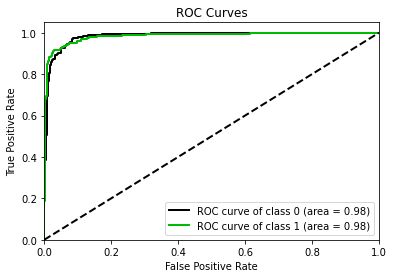

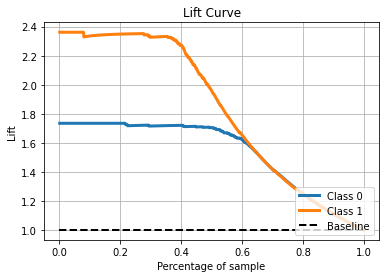

In [825]:
clf = LGBMClassifier(class_weight=class_weights, colsample_bytree = 0.3, learning_rate = .001, max_depth = 9, n_estimators = 500, objective = 'binary')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf.fit(X_train, y_train)
y_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print('Confusion Matrix:', '\n', confusion_matrix(y_test, y_pred), '\n')

print('Testing set cost_loss:', cost_loss(y_test, y_pred), '\n')

# Showing the classificatino report
print(classification_report(y_test, y_pred))

# Plot the ROC Curve
y_pred_proba = clf.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_pred_proba, plot_micro = False, plot_macro = False)
    
# Plot the Lift Curve
skplt.metrics.plot_lift_curve(y_test, y_pred_proba)
plt.show()